<a href="https://colab.research.google.com/github/KeisukeShimokawa/papers-challenge/blob/master/src/gan/SSGAN/notebooks/SSGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip freeze | grep torch

torch==1.5.0+cu101
torchsummary==1.5.1
torchtext==0.3.1
torchvision==0.6.0+cu101


In [2]:
!nvidia-smi | head -n 10

Sat May 23 12:56:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+


## Config

In [0]:
import dataclasses

In [0]:
@dataclasses.dataclass
class Config:
    # global setting
    use_cuda: bool = True
    seed: int = 42

    # dataset
    dataset: str = "cifar10"
    data_path: str = "./data"
    batch_size: int = 128
    image_size: int = 128

    # model
    resnet: bool = True
    nz: int = 100
    nc: int = 3
    use_sn: bool = True
    num_rot: int = 4
    ssup: bool = True

    # training
    lrG: float = 1e-4
    lrD: float = 1e-5
    beta1: float = 0.9
    beta2: float = 0.99
    n_epoch: int = 200
    weight_rot_g: float = 0.5
    weight_rot_d: float = 1.0

    @property
    def betas(self):
        return (self.beta1, self.beta2)

    @property
    def is_cuda(self):
        return self.use_cuda and torch.cuda.is_available()

In [123]:
cfg = Config()

print(cfg)

Config(use_cuda=True, seed=42, dataset='cifar10', data_path='./data', batch_size=128, image_size=128, resnet=True, nz=100, nc=3, use_sn=True, num_rot=4, ssup=True, lrG=0.0001, lrD=1e-05, beta1=0.9, beta2=0.99, n_epoch=200, weight_rot_g=0.5, weight_rot_d=1.0)


In [0]:
import os
import random
import numpy as np
import torch


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [35]:
if cfg.seed:
    set_seed(cfg.seed)
    print(f"set seed: {cfg.seed}")

set seed: 42


In [36]:
is_cuda = cfg.use_cuda and torch.cuda.is_available()
device = torch.device("cuda:0" if is_cuda else "cpu")

print(f"set device: {device}")

set device: cuda:0


## Dataset

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid, save_image

In [0]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets as dsets
from torchvision import transforms

In [0]:
def get_cifar10(cfg):
    all_transforms = transforms.Compose([
        transforms.Resize(cfg.image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ])

    train_data = dsets.CIFAR10(
        root=cfg.data_path,
        train=True,
        download=True,
        transform=all_transforms
    )
    test_data = dsets.CIFAR10(
        root=cfg.data_path,
        train=False,
        transform=all_transforms
    )

    train_loader = DataLoader(train_data, batch_size=cfg.batch_size, shuffle=True)
    test_loader  = DataLoader(test_data,  batch_size=cfg.batch_size, shuffle=True)

    return train_loader, test_loader

In [9]:
train_loader, test_loader = get_cifar10(cfg)

Extracting ./data/cifar-10-python.tar.gz to ./data


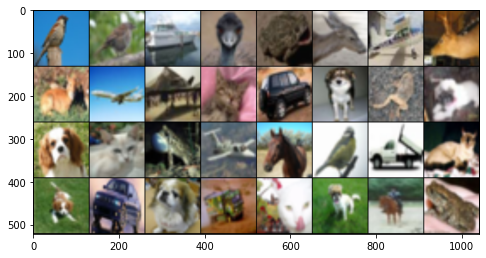

In [10]:
images, labels = next(iter(train_loader))

grid_tensor = np.transpose(make_grid(images[:32], padding=2, normalize=True).numpy(), (1,2,0))
plt.figure(figsize=(8, 8))
plt.imshow(grid_tensor)

## Model

### Modules

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import spectral_norm
from torchsummary import summary

In [0]:
def log_sum_exp(x, axis=-1):
    m = torch.max(x, keepdim=True)
    return m + torch.logsumexp(x - m, dim=1, keepdim=True)

In [0]:
class Conv2d(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1, use_sn=True):
        super(Conv2d, self).__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        if use_sn:
            self.conv = spectral_norm(self.conv)

    def forward(self, inputs):
        out = self.conv(inputs)
        return out

In [0]:
class ConvTranspose2d(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1, use_sn=True, iter=-1):
        super(ConvTranspose2d, self).__init__()

        self.convtranspose = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding)
        if use_sn:
            self.convtranspose = spectral_norm(self.convtranspose)

    def forward(self, inputs):
        out = self.convtranspose(inputs)
        return out

In [0]:
class Residual_G(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, use_sn=True, is_up=True):
        super(Residual_G, self).__init__()

        self.is_up = is_up
        self.activation = nn.LeakyReLU(0.2, inplace=True)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.upsample = nn.Upsample(scale_factor=2, mode="nearest")
        self.conv_short = Conv2d(in_channels, out_channels, kernel_size=1, stride=1, 
                                 padding=0, use_sn = False)
        self.conv1 = Conv2d(in_channels, out_channels, kernel_size=kernel_size, 
                            stride=stride, padding=1, use_sn=use_sn)
        self.conv2 = Conv2d(out_channels, out_channels, kernel_size=kernel_size, 
                            stride=stride, padding=1, use_sn=use_sn)
        
    def forward(self, inputs):
        residual = inputs
        out = self.activation(self.bn1(inputs))
        if self.is_up:
            out = self.upsample(out)
        out = self.conv1(out)
        out = self.activation(self.bn2(out))
        out = self.conv2(out)

        if self.is_up:
            residual = self.upsample(residual)
        residual = self.conv_short(residual)

        return out + residual

In [51]:
Residual_G(32, 64, 3, 1)(torch.randn(10, 32, 64, 64)).shape

torch.Size([10, 64, 128, 128])

In [0]:
class Residual_D(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, use_sn=True, is_down=True, is_start=False):
        super(Residual_D, self).__init__()

        self.is_down = is_down
        self.is_start = is_start
        self.activation = nn.LeakyReLU(0.2, inplace=True)
        self.avgpool_short = nn.AvgPool2d(2, 2)
        self.conv_short = Conv2d(in_channels, out_channels, kernel_size=1, stride=1, 
                                 padding=0, use_sn = False)
        self.conv1 = Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, 
                            padding=1, use_sn=use_sn)
        self.conv2 = Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=stride, 
                            padding=1, use_sn=use_sn)
        self.avgpool2 = nn.AvgPool2d(2, 2)

    def forward(self, inputs):
        residual = inputs
        if self.is_start:
            out = self.activation(self.conv1(inputs))
            out = self.activation(self.conv2(out))
            if self.is_down:
                out = self.avgpool2(out)
        else:
            out = self.conv1(self.activation(inputs))
            out = self.conv2(self.activation(out))
            if self.is_down:
                out = self.avgpool2(out)

        if self.is_down:
            residual = self.avgpool_short(residual)
        residual = self.conv_short(residual)

        return out + residual

In [18]:
Residual_D(32, 64, 3, 1)(torch.randn(10, 32, 64, 64)).shape

torch.Size([10, 64, 32, 32])

### Generator

In [0]:
class VanillaGenerator(nn.Module):

    def __init__(self, nz, nc, image_size=32):
        super(VanillaGenerator, self).__init__()

        self.nz = nz
        self.nc = nc
        self.image_size = image_size
        if image_size == 32:  self.s = 4
        if image_size == 64:  self.s = 8
        if image_size == 128: self.s = 16

        self.activation = nn.ReLU(inplace=True)
        self.linear_first = nn.Linear(nz, self.s*self.s*256)
        self.bn1 = nn.BatchNorm1d(self.s*self.s*256)
        self.conv2 = ConvTranspose2d(256, 256, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(256)
        self.conv3 = ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = ConvTranspose2d(128,  64, kernel_size=4, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv_last = ConvTranspose2d(64,  nc, kernel_size=3, stride=1, padding=1)
        self.tanh = nn.Tanh()

    def forward(self, inputs):
        out = self.activation(self.linear_first(inputs))
        out = out.view(-1, 256, self.s, self.s)
        out = self.activation(self.bn2(self.conv2(out)))
        out = self.activation(self.bn3(self.conv3(out)))
        out = self.activation(self.bn4(self.conv4(out)))
        out = self.conv_last(out)

        return self.tanh(out)

    def sample_latent_codes(self, batch_size):
        return torch.randn((batch_size, self.nz))

In [47]:
VanillaGenerator(100, 3, 32)(torch.randn(10, 100)).shape

torch.Size([10, 3, 32, 32])

In [92]:
summary(VanillaGenerator(100, 3, 32).to(device), (100,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 4096]         413,696
              ReLU-2                 [-1, 4096]               0
   ConvTranspose2d-3            [-1, 256, 8, 8]       1,048,832
   ConvTranspose2d-4            [-1, 256, 8, 8]               0
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,416
   ConvTranspose2d-8          [-1, 128, 16, 16]               0
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
  ConvTranspose2d-11           [-1, 64, 32, 32]         131,136
  ConvTranspose2d-12           [-1, 64, 32, 32]               0
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

In [0]:
class ResNetGenerator(nn.Module):

    def __init__(self, nz, nc, image_size=32):
        super(ResNetGenerator, self).__init__()

        self.nz = nz
        self.nc = nc
        self.image_size = image_size
        if image_size == 32:  self.s = 4
        if image_size == 64:  self.s = 8
        if image_size == 128: self.s = 16

        self.activation = nn.ReLU(inplace=True)
        self.linear_first = nn.Linear(nz, self.s*self.s*256)
        self.block1 = Residual_G(256, 256, is_up=True)
        self.block2 = Residual_G(256, 256, is_up=True)
        self.block3 = Residual_G(256, 256, is_up=True)
        self.conv_last = ConvTranspose2d(256,  nc, kernel_size=3, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(256)
        self.tanh = nn.Tanh()

    def forward(self, inputs):
        out = self.activation(self.linear_first(inputs))
        out = out.view(-1, 256, self.s, self.s)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.conv_last(self.activation(self.bn(out)))

        return self.tanh(out)

    def sample_latent_codes(self, batch_size):
        return torch.randn((batch_size, self.nz))

In [56]:
ResNetGenerator(100, 3, 32)(torch.randn(10, 100)).shape

torch.Size([10, 3, 32, 32])

In [93]:
summary(ResNetGenerator(100, 3, 32).to(device), (100,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 4096]         413,696
              ReLU-2                 [-1, 4096]               0
       BatchNorm2d-3            [-1, 256, 4, 4]             512
         LeakyReLU-4            [-1, 256, 4, 4]               0
          Upsample-5            [-1, 256, 8, 8]               0
            Conv2d-6            [-1, 256, 8, 8]         590,080
            Conv2d-7            [-1, 256, 8, 8]               0
       BatchNorm2d-8            [-1, 256, 8, 8]             512
         LeakyReLU-9            [-1, 256, 8, 8]               0
           Conv2d-10            [-1, 256, 8, 8]         590,080
           Conv2d-11            [-1, 256, 8, 8]               0
         Upsample-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]          65,792
           Conv2d-14            [-1, 25

### Discriminator

In [0]:
class VanillaDiscriminator(nn.Module):

    def __init__(self, nc, use_sn, num_rot, ssup):
        super(VanillaDiscriminator, self).__init__()

        self.num_rot = num_rot
        self.ssup = ssup

        self.activation = nn.LeakyReLU(0.2, inplace=True)
        self.conv1 = Conv2d(nc, 64, kernel_size=3, stride=1, padding=1, use_sn=use_sn)
        self.conv2 = Conv2d( 64, 128, padding=1, use_sn=use_sn)
        self.conv3 = Conv2d(128, 256, padding=1, use_sn=use_sn)
        self.conv4 = Conv2d(256, 512, padding=1, use_sn=use_sn)
        self.linear_gan = nn.Linear(512*4, 1)
        self.linear_rot = nn.Linear(512*4, 4)
        self.softmax = nn.Softmax()
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputs):
        out = self.activation(self.conv1(inputs))
        out = self.activation(self.conv2(out))
        out = self.activation(self.conv3(out))
        out = self.activation(self.conv4(out))
        # out = F.adaptive_avg_pool2d(out, output_size=(1, 1)); print(out.shape)
        flatten = out.view(out.size(0)*self.num_rot, -1)
        gan_logits = self.linear_gan(flatten)
        if self.ssup:
            rot_logits = self.linear_rot(flatten)
            rot_probs = self.softmax(rot_logits)
            return self.sigmoid(gan_logits), gan_logits, rot_probs, rot_logits

        return self.sigmoid(gan_logits), gan_logits

In [90]:
VanillaDiscriminator(3, True, 4, True)(torch.randn(10, 3, 32, 32))[0].shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


torch.Size([40, 1])

In [91]:
summary(VanillaDiscriminator(3, True, 4, True).to(device), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
            Conv2d-2           [-1, 64, 32, 32]               0
         LeakyReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 16, 16]         131,200
            Conv2d-5          [-1, 128, 16, 16]               0
         LeakyReLU-6          [-1, 128, 16, 16]               0
            Conv2d-7            [-1, 256, 8, 8]         524,544
            Conv2d-8            [-1, 256, 8, 8]               0
         LeakyReLU-9            [-1, 256, 8, 8]               0
           Conv2d-10            [-1, 512, 4, 4]       2,097,664
           Conv2d-11            [-1, 512, 4, 4]               0
        LeakyReLU-12            [-1, 512, 4, 4]               0
           Linear-13                    [-1, 1]           2,049
           Linear-14                   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
class ResNetDiscriminator(nn.Module):

    def __init__(self, nc, use_sn, num_rot, ssup):
        super(ResNetDiscriminator, self).__init__()

        self.num_rot = num_rot
        self.ssup = ssup

        self.activation = nn.LeakyReLU(0.2, inplace=True)
        self.block1 = Residual_D( nc, 256, use_sn=use_sn, is_down=True, is_start=True)
        self.block2 = Residual_D(256, 256, use_sn=use_sn, is_down=True)
        self.block3 = Residual_D(256, 256, use_sn=use_sn)
        self.block4 = Residual_D(256, 256, use_sn=use_sn)
        self.linear_gan = nn.Linear(256, 1)
        self.linear_rot = nn.Linear(256, 4)
        self.softmax = nn.Softmax()
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputs):
        out = self.block1(inputs)
        out = self.block2(out)
        out = self.block3(out)
        out = self.activation(self.block4(out))
        flatten = out.view(out.size(0)*self.num_rot, -1)
        gan_logits = self.linear_gan(flatten)
        if self.ssup:
            rot_logits = self.linear_rot(flatten)
            rot_probs = self.softmax(rot_logits)
            return self.sigmoid(gan_logits), gan_logits, rot_probs, rot_logits

        return self.sigmoid(gan_logits), gan_logits

In [111]:
ResNetDiscriminator(3, True, 4, True)(torch.randn(10, 3, 32, 32))[0].shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


torch.Size([40, 1])

In [112]:
summary(ResNetDiscriminator(3, True, 4, True).to(device), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 256, 32, 32]           7,168
            Conv2d-2          [-1, 256, 32, 32]               0
         LeakyReLU-3          [-1, 256, 32, 32]               0
            Conv2d-4          [-1, 256, 32, 32]         590,080
            Conv2d-5          [-1, 256, 32, 32]               0
         LeakyReLU-6          [-1, 256, 32, 32]               0
         AvgPool2d-7          [-1, 256, 16, 16]               0
         AvgPool2d-8            [-1, 3, 16, 16]               0
            Conv2d-9          [-1, 256, 16, 16]           1,024
           Conv2d-10          [-1, 256, 16, 16]               0
       Residual_D-11          [-1, 256, 16, 16]               0
        LeakyReLU-12          [-1, 256, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         590,080
           Conv2d-14          [-1, 256,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


## Prepare Model

In [0]:
import torch.optim as optim

In [0]:
netG = VanillaGenerator(cfg.nz, cfg.nc, cfg.image_size).to(device)
netD = VanillaDiscriminator(cfg.nc, cfg.use_sn, cfg.num_rot, cfg.ssup).to(device)

optimizerG = optim.Adam(netG.parameters(), lr=cfg.lrG, betas=cfg.betas)
optimizerD = optim.Adam(netD.parameters(), lr=cfg.lrD, betas=cfg.betas)

## Train

In [0]:
def critic_train_iteration(netD, optimD, data, generated_data, cfg):
    data = data.to(device)
    _, d_real_pro_logits, d_real_rot_probs, d_real_rot_logist = netD(data)
    _, d_real_pro_logits, d_real_rot_probs, d_real_rot_logist = netD(generated_data)

    optimD.zero_grad()
    d_loss = torch.sum(g_fake_pro_logits) - torch.sum(d_real_pro_logits)

    # Add auxiiary rotation loss
    rot_labels = torch.zeros(4*cfg.batch_size).to(device=data.device)
    for i in range(4*bcfg.atch_size):
        if i < cfg.batch_size:
            rot_labels[i] = 0
        elif i < 2*cfg.batch_size:
            rot_labels[i] = 1
        elif i < 3*cfg.batch_size:
            rot_labels[i] = 2
        else:
            rot_labels[i] = 3

    rot_labels = F.one_hot(rot_labels.to(torch.int64), 4).float()
    d_real_class_loss = torch.sum(F.binary_cross_entropy_with_logits(
                                  input = d_real_rot_logits,
                                  target = rot_labels))

    d_loss += cfg.weight_rot_d * d_real_class_loss
    d_loss.backward(retain_graph=True)

    netD.step()

In [0]:
def _generator_train_iteration(netG, netD, optimG, generated_data, cfg):
    
    optimG.zero_grad()

    # Calculate loss and optimize
    _, g_fake_pro_logits, g_fake_rot_prob, g_fake_rot_logits = netD(generated_data)
    g_loss = - torch.sum(g_fake_pro_logits)

    # add auxiliary rotation loss
    rot_labels = torch.zeros(4*cfg.batch_size,).to(device=generated_data.device)
    for i in range(4*cfg.batch_size):
        if i < cfg.batch_size:
            rot_labels[i] = 0
        elif i < 2*cfg.batch_size:
            rot_labels[i] = 1
        elif i < 3*cfg.batch_size:
            rot_labels[i] = 2
        else:
            rot_labels[i] = 3
    
    rot_labels = F.one_hot(rot_labels.to(torch.int64), 4).float()
    g_fake_class_loss = torch.sum(F.binary_cross_entropy_with_logits(
        input = g_fake_rot_logits, 
        target = rot_labels))
    
    g_loss += cfg.weight_rot_g * g_fake_class_loss
    g_loss.backward(retain_graph=True)
    optimG.step()


In [0]:
def sample_generator(netG, num_samples, cfg):
    latent_samples = netG.sample_latent(num_samples)
    if cfg.use_cuda:
        latent_samples = latent_samples.cuda()
    generated_data = self.G(latent_samples)
    return generated_data


def sample(self, num_samples):
    generated_data = sample_generator(num_samples)
    # Remove color channel
    return generated_data.data.cpu().numpy()[:, 0, :, :]

In [0]:
def _train_epoch(data_loader, device):
    for i, data in enumerate(data_loader):
        # Get generated data
        data = data[0]
        batch_size = data.size()[0]
        generated_data = self.sample_generator(batch_size)
        
        x = generated_data
        x_90 = x.transpose(2,3)
        x_180 = x.flip(2,3)
        x_270 = x.transpose(2,3).flip(2,3)
        generated_data = torch.cat((x, x_90, x_180, x_270),0)

        x = data
        x_90 = x.transpose(2,3)
        x_180 = x.flip(2,3)
        x_270 = x.transpose(2,3).flip(2,3)
        data = torch.cat((x,x_90,x_180,x_270),0)

        self.num_steps += 1
        self._critic_train_iteration(data, generated_data, batch_size)
        # Only update generator every |critic_iterations| iterations
        if self.num_steps % self.critic_iterations == 0:
            self._generator_train_iteration(generated_data, batch_size)

        if i % self.print_every == 0:
            print("Iteration {}".format(i + 1))
            print("D: {}".format(self.losses['D'][-1]))
            print("GP: {}".format(self.losses['GP'][-1]))
            print("Gradient norm: {}".format(self.losses['gradient_norm'][-1]))
            if self.num_steps > self.critic_iterations:
                print("G: {}".format(self.losses['G'][-1]))